In [11]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import glob
import pickle
from IPython.display import display, Latex
import logomaker

import adabmDCA
from adabmDCA.functional import one_hot
from adabmDCA.utils import get_device, get_dtype

import sys
sys.path.append('..')
import selex_dca
import utils
import indep_sites

In [2]:
experiment_ids = ['Dop8V030', 'Dop8V930', 'Dop8V2430']
round_ids = ["ARN", "R01", "R02N"]
ns = range(len(experiment_ids))
ts = torch.arange(len(round_ids))
device = get_device("")
dtype = get_dtype("float32")

Running on CPU


In [8]:
# sequences_all = [[selex_dca.sequences_from_file(experiment_id, round_id, device) 
#                   for round_id in round_ids] for experiment_id in experiment_ids];

In [9]:
# pseudocount = 0.0

# freq_single_tuple, freq_pair_tuple, total_reads_tuple = zip(*[zip(*[
#     selex_dca.frequences_from_sequences(seq, pseudo_count=pseudocount, dtype=dtype) 
#     for seq in sequences]) for sequences in sequences_all])

# fi_all = [torch.stack(f) for f in freq_single_tuple] 
# fij_all = [torch.stack(f) for f in freq_pair_tuple]
# total_reads_all = [torch.tensor(tr, dtype=dtype) for tr in total_reads_tuple]

In [26]:
def load_frequencies():       
    filepath = "saved/frequencies.pkl" 
    
    with open(filepath, 'rb') as f:
        fi_all, fij_all, total_reads_all, pseudocount = pickle.load(f)

    return fi_all, fij_all, total_reads_all, pseudocount

In [28]:
fi_all, fij_all, total_reads_all, pseudocount = load_frequencies()

In [39]:
n_rounds, L, q = fi_all[0].size()

In [29]:
lr = 0.01
max_epochs = 5*10**4

params_all = []
history_all = []

for n in range(len(experiment_ids)):
    params=indep_sites.init_parameters(fi_all[n])
    params, history = indep_sites.train(
        fi=fi_all[n],
        total_reads=total_reads_all[n], 
        params=params,
        lr=lr,
        max_epochs=max_epochs,
        target_error=1e-6,
        progress_bar=False)
    
    params_all.append(params)
    history_all.append(history)

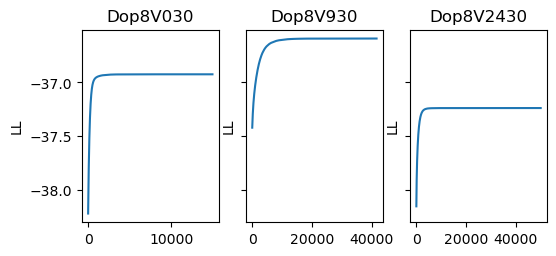

In [30]:
fig, axes = plt.subplots(1,3, sharey=True, figsize=(6,2.5))
for n in range(len(experiment_ids)):
    ax = axes[n]
    ax.plot(history_all[n]["log-likelihood"])
    ax.set_title(f"{experiment_ids[n]}")
    ax.set_ylabel("LL")

In [35]:
params_zerosum_all = [utils.set_zerosum_gauge(params_all[n])
                      for n in range(len(params_all))]

## Save parameters and frequencies

In [20]:
# filename = "params_indep_sites.pkl"
# filepath = "saved/" + filename

# data = [experiment_ids, round_ids, params_zerosum_all]

# with open(filepath, 'wb') as f:
#     pickle.dump(data, f)

# filepath = "saved/frequencies.pkl" 

# data = [fi_all, fij_all, total_reads_all, pseudocount]

# with open(filepath, 'wb') as f:
#     pickle.dump(data, f)

## Look at parameters

<IPython.core.display.Latex object>

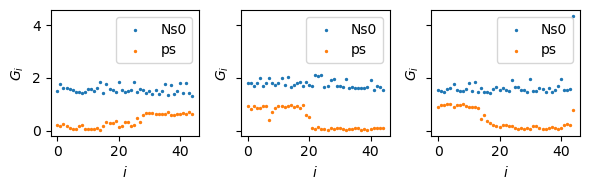

In [47]:
fig, axes = plt.subplots(1,3,figsize=(6,2), sharex=True, sharey=True)

display(Latex("$G_{i}=\\sqrt {\\sum_{a}(h_{i}^{a})^2}$"))

for n in ns:
    ax = axes[n]
    x = range(L)
    y = params_zerosum_all[n]['bias_Ns0']
    y = torch.sqrt(torch.square(y).sum(dim=1))
    ax.scatter(x, y, s=2, label="Ns0")
    y = params_zerosum_all[n]['bias_ps']
    y = torch.sqrt(torch.square(y).sum(dim=1))
    ax.scatter(x, y, s=2, label="ps")
    ax.legend()
    ax.set_xlabel("$i$"); ax.set_ylabel("$G_i$")
plt.tight_layout()

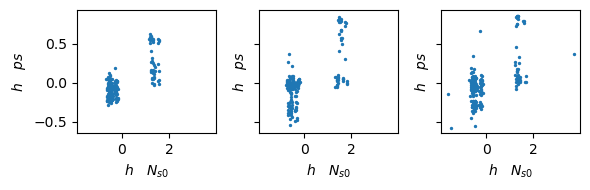

In [66]:
fig, axes = plt.subplots(1,3,figsize=(6,2), sharex=True, sharey=True)

# display(Latex("$G_{i}=\\sqrt {\\sum_{a}(h_{i}^{a})^2}$"))

for n in ns:
    ax = axes[n]
    x = params_zerosum_all[n]['bias_Ns0'].reshape(-1)
    y = params_zerosum_all[n]['bias_ps'].reshape(-1)
    ax.scatter(x, y, s=2)
    # ax.legend()
    ax.set_xlabel("$h\\quad N_{s0}$"); ax.set_ylabel("$h\\quad ps$")
plt.tight_layout()

Compare with Potts

In [63]:
data = []

for filepath in sorted(glob.iglob('./saved/*.pkl')):
    if filepath[8:11] == 'Dop':
        with open(filepath, 'rb') as f:
            data.append(pickle.load(f))

print(f"Loaded {len(data)} files.")

data = [data[i] for i in [0,2,1]]

experiment_id_all, round_ids_all, params_potts_all = zip(*data)
assert(experiment_id_all == tuple(experiment_ids))

params_potts_zerosum_all = [utils.set_zerosum_gauge(params_potts_all[n])
                      for n in range(len(params_potts_all))]

Loaded 3 files.


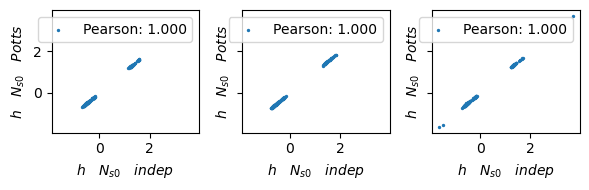

In [68]:
fig, axes = plt.subplots(1,3,figsize=(6,2), sharex=True, sharey=True)

for n in ns:
    ax = axes[n]
    x = params_zerosum_all[n]['bias_Ns0'].reshape(-1)
    y = params_potts_zerosum_all[n]['bias_Ns0'].reshape(-1)
    rho = torch.corrcoef(torch.stack((x,y)))[0,1]
    ax.scatter(x, y, s=2, label=f"Pearson: {rho:.3f}")
    ax.legend()
    ax.set_xlabel("$h\\quad N_{s0}\\quad indep$"); ax.set_ylabel("$h\\quad N_{s0} \\quad Potts$")
plt.tight_layout()

## Compute logNst cross-dataset without loading too much in memory

In [26]:
import importlib

importlib.reload(utils)
importlib.reload(selex_dca)
importlib.reload(indep_sites)

<module 'indep_sites' from '/home/scrotti/Aptamer2025py/experiments/../indep_sites.py'>

In [27]:
import gc

def run_and_save(n, N):
    print(f'Starting dataset {n}...')
    sequences_n = sequences_all[n]
    # Compute logNst of sequences in dataset n with parameters learned from dataset n, except use the Ns0
    #  learned from dataset n
    logNst_n, sequences_unique_n, sequences_unique_oh_n, inverse_indices_n, counts_n = zip(*[
        indep_sites.compute_logNst(
            sequences_n, params=params_zerosum_all[m], params_Ns0=params_zerosum_all[n]
            ) for m in ns]
    )

    pearsons_n = [[torch.corrcoef(torch.stack((logNst_n[m][t],logNst_n[n][t])))[0,1] 
               for t in ts] for m in ns]

    idx = [random.sample(range(len(logNst_n[0][t])), min(N,len(logNst_n[0][t])))  for t in ts]
    X_n, Y_n = zip(*[zip(*[(logNst_n[m][t][idx[t]], logNst_n[n][t][idx[t]]) for t in ts]) for m in ns])
    
    filename = experiment_ids[n] + ".pkl"
    filepath = "saved/plot_Nst_indep_sites/" + filename
    
    data = [pearsons_n, X_n, Y_n]
    
    with open(filepath, 'wb') as f:
        pickle.dump(data, f)

    print(f'Finished dataset {n}')
    gc.collect()

In [28]:
N = 10**4

for n in ns:
    run_and_save(n, N)

Starting dataset 0...
Finished dataset 0
Starting dataset 1...
Finished dataset 1
Starting dataset 2...
Finished dataset 2


Load

In [29]:
data = []

for filepath in sorted(glob.iglob('./saved/plot_Nst_indep_sites/*.pkl')):
    print('File ' + filepath)
    with open(filepath, 'rb') as f:
        data.append(pickle.load(f))

print(f"Loaded {len(data)} files.")

data = [data[i] for i in [0,2,1]]

pearsons, X, Y = zip(*data)

File ./saved/plot_Nst_indep_sites/Dop8V030.pkl
File ./saved/plot_Nst_indep_sites/Dop8V2430.pkl
File ./saved/plot_Nst_indep_sites/Dop8V930.pkl
Loaded 3 files.


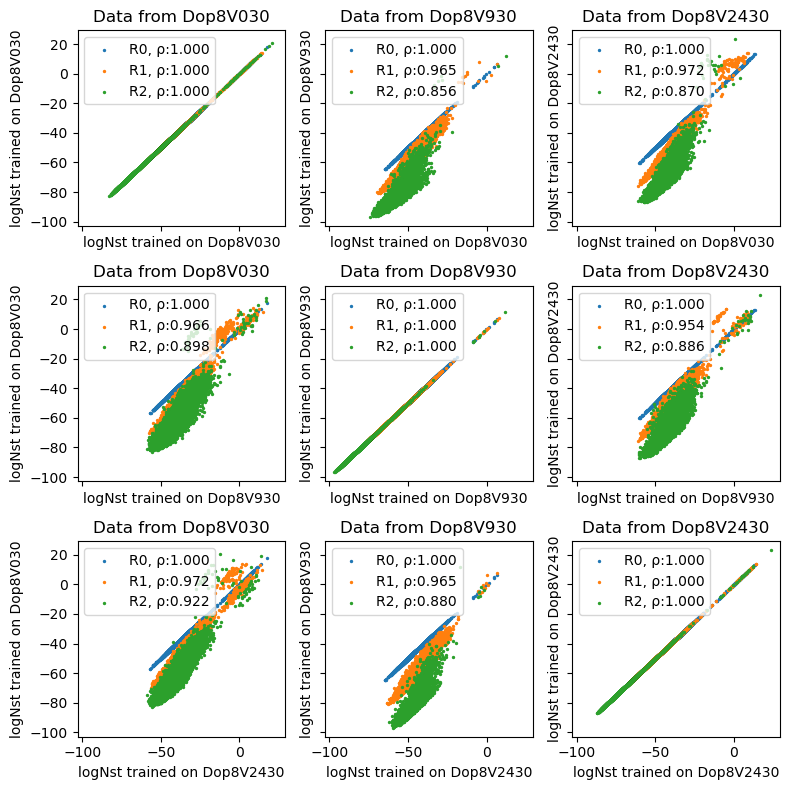

In [30]:
fig, axes = plt.subplots(3,3,figsize=(8,8), sharex=True, sharey=True)

for m in ns:
    for n in ns:
        ax = axes[m,n]
        for t in ts:
            ax.scatter(X[n][m][t], Y[n][m][t], label=f"R{t}, ρ:{pearsons[n][m][t]:.3f}", s=2)
            ax.set_xlabel("logNst trained on " + experiment_ids[m])
            ax.set_ylabel("logNst trained on " + experiment_ids[n])
            ax.set_title("Data from " + experiment_ids[n])
            ax.legend()
plt.tight_layout()
plt.savefig('img/logNst_indep_sites_ownNs0.png')

In [35]:
def run_and_save2(n, N):
    print(f'Starting dataset {n}...')
    sequences_all_n = torch.cat(sequences_all[n], dim=0)
    sequences_all_unique_n = torch.unique(sequences_all_n, dim=0)
    sequences_all_unique_oh_n = one_hot(sequences_all_unique_n)
    
    logNst_unique = [-indep_sites.compute_energy(
        sequences_all_unique_oh_n, 
        indep_sites.get_params_at_round(params_zerosum_all[n], t))
               for t in ts]
    
    M_logNst = torch.stack(logNst_unique).numpy()
    corrs = np.corrcoef(M_logNst)
    
    fig, axes = plt.subplots(3,3, figsize=(6,6), sharex=True, sharey=True)
    
    for t in ts:
        for u in ts:
            ax = axes[u,t]
            x = logNst_unique[t]
            y = logNst_unique[u]
            idx = random.sample(range(len(x)),min(N, len(x)))
            ax.scatter(x[idx], y[idx], label=f"ρ: {corrs[t,u]:.3f}", s=2)
            ax.set_xlabel("Round " + str(t.item()))
            ax.set_ylabel("Round " + str(u.item()))
            ax.legend()
    plt.tight_layout()
    
    plt.savefig(f"img/{experiment_ids[n]}_corr_Ns0_indep_sites.png")

Starting dataset 0...
Starting dataset 1...
Starting dataset 2...


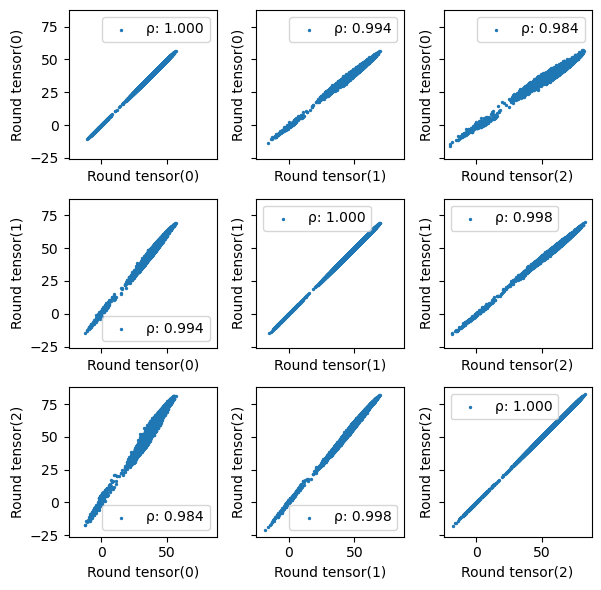

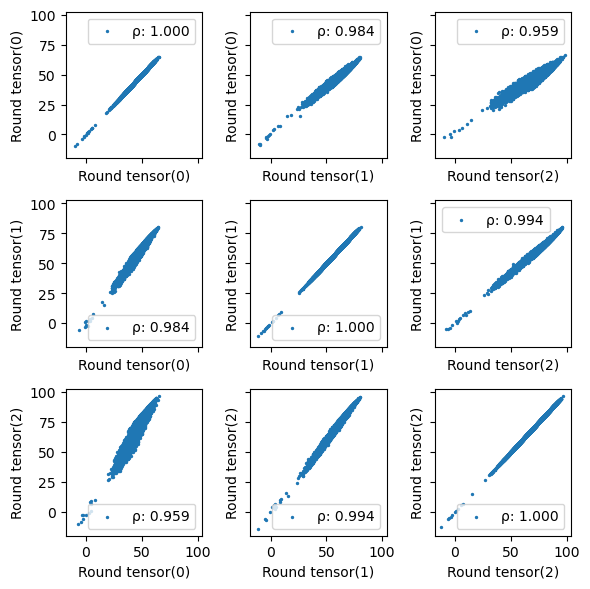

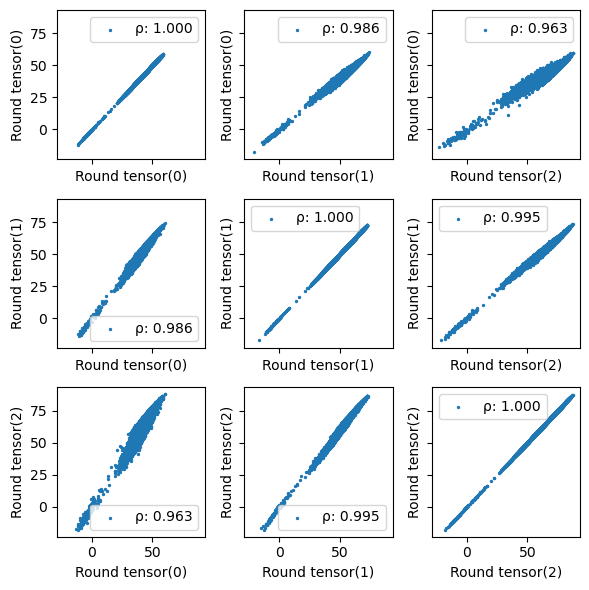

In [36]:
N = 10**4

for n in ns:
    run_and_save2(n, N)

# Compare across datasets

In [110]:
sequences_all = [[selex_dca.sequences_from_file(experiment_id, round_id, device) 
                  for round_id in round_ids] for experiment_id in experiment_ids];

In [ ]:
sequences_unique_all, inverse_indices_all, counts_all = zip(*[zip(*[
    torch.unique(seq_t, dim=0, return_inverse=True, return_counts=True)
    for seq_t in sequences_all[n]]) for n in ns])

In [116]:
sequences_unique_oh_all = [[adabmDCA.functional.one_hot(s) for s in sequences_unique_all[n]] for n in ns]

In [117]:
filepath = './saved/wildtypes_sites.pkl'
with open(filepath, 'rb') as f:
    wts = pickle.load(f)

wts_oh = [adabmDCA.functional.one_hot(wts[n][None,:]) for n in ns]

### log ps

In [390]:
params_ps_all = [indep_sites.get_params_ps(params_all[n]) for n in ns]

In [406]:
logps_cross = [[[-indep_sites.compute_energy(
    sequences_unique_oh_all[m][t], params_ps_all[n]) 
              for t in ts] for n in ns] for m in ns]

In [392]:
logps_wt_cross = [[-indep_sites.compute_energy(wts_oh[m], params_ps_all[n]) 
                    for n in ns] for m in ns]

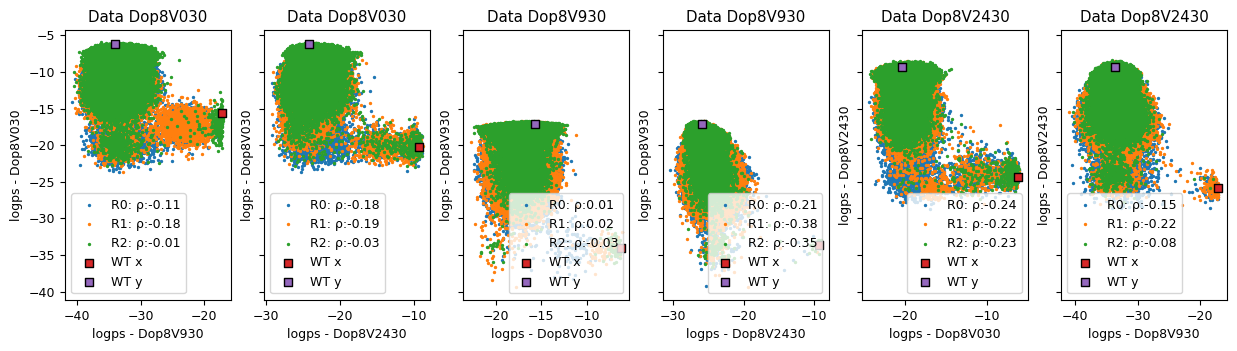

In [407]:
N = 10**5

fig, axes = plt.subplots(1, 6, figsize=(15,3.5), sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=9) 

j = -1
for m in ns:
    for n in ns:
        if m != n:
            j += 1
            ax = axes[j]
            for t in ts:
                x = logps_cross[m][n][t]
                y = logps_cross[m][m][t]
                pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
                idx = random.sample(range(len(x)),min(N, len(x)))
                ax.scatter(x[idx], y[idx], label=f"R{t}: ρ:{pearson:.{2}f}", s=2, color=colors[t])
                ax.set_xlabel(f"logps - {experiment_ids[n]}")
                ax.set_ylabel(f"logps - {experiment_ids[m]}")
                ax.set_title(f"Data {experiment_ids[m]}")
            ax.scatter(logps_wt_cross[n][n], logps_wt_cross[n][m], marker='s',
                       edgecolor='black', label="WT x", color=colors[3])
            ax.scatter(logps_wt_cross[m][n], logps_wt_cross[m][m], marker='s',
                       edgecolor='black', label="WT y", color=colors[4])
            ax.legend()
# plt.tight_layout()
plt.savefig('img/logps_cross_indep_sites.png')

## logNst

In [408]:
params_Nst_all = [[indep_sites.get_params_at_round(params_all[n], t) for t in ts] for n in ns]

In [409]:
logNst_cross = [[[-indep_sites.compute_energy(
    sequences_unique_oh_all[m][t], params_Nst_all[n][t]) 
              for t in ts] for n in ns] for m in ns]

In [410]:
logNst_wt_cross = [[[-indep_sites.compute_energy(wts_oh[m], params_Nst_all[n][t]) 
                     for t in ts] for n in ns] for m in ns]

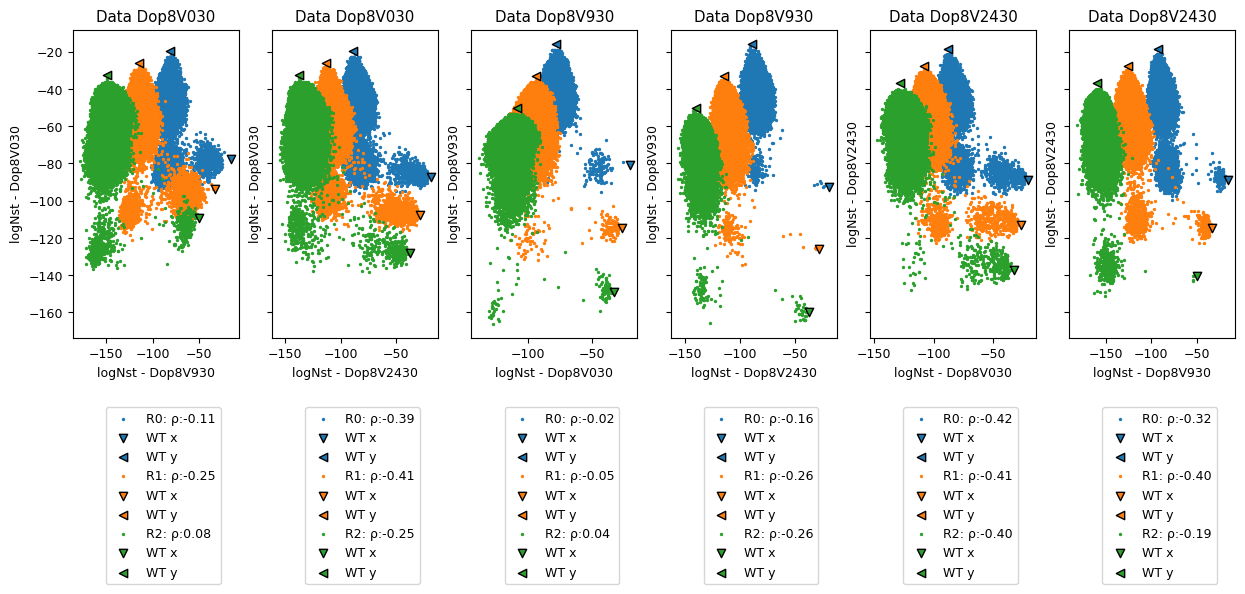

In [424]:
N = 10**5

fig, axes = plt.subplots(1, 6, figsize=(15,4), sharey=True)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font', size=9) 

j = -1
for m in ns:
    for n in ns:
        if m != n:
            j += 1
            ax = axes[j]
            for t in ts:
                x = logNst_cross[m][n][t]
                y = logNst_cross[m][m][t]
                pearson = torch.corrcoef(torch.stack((x,y)))[0,1]            
                idx = random.sample(range(len(x)),min(N, len(x)))
                ax.scatter(x[idx], y[idx], label=f"R{t}: ρ:{pearson:.{2}f}", s=2, color=colors[t])
                ax.set_xlabel(f"logNst - {experiment_ids[n]}")
                ax.set_ylabel(f"logNst - {experiment_ids[m]}")
                ax.set_title(f"Data {experiment_ids[m]}")
            # ax.scatter(logps_wt_cross[n][n], logps_wt_cross[n][m], marker='s',
            #            edgecolor='black', label="WT x", color=colors[3])
            # ax.scatter(logps_wt_cross[m][n], logps_wt_cross[m][m], marker='s',
            #            edgecolor='black', label="WT y", color=colors[4])
                ax.scatter(logNst_wt_cross[n][n][t], logNst_wt_cross[n][m][t], marker='v',
                       edgecolor='black', label="WT x", color=colors[t])
                ax.scatter(logNst_wt_cross[m][n][t], logNst_wt_cross[m][m][t], marker='<',
                       edgecolor='black', label="WT y", color=colors[t])
            ax.legend(loc=(0.2,-0.8))
# plt.tight_layout()
plt.savefig('img/logNst_cross_indep_sites.png')